In [16]:
# Importing libraries ---------------------------------------------------------- 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm' 
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 100
# Read dataset ----------------------------------------------------------------- 
df = pd.read_csv('Combined_Flights_2018.csv', usecols=['Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepDelay', 'CRSElapsedTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'IATA_Code_Operating_Airline', 'CRSArrTime', 'ArrDelay', 'ArrivalDelayGroups'])
# Data preprocessing ----------------------------------------------------------- 
# drop cancelled flights 
df_col = df.loc[df['Cancelled'] == False]
df_col = df_col.drop('Cancelled', axis=1)
# simplify column names 
df_col.rename(columns = {'CRSDepTime': 'DepTime', 'CRSElapsedTime': 'ElapsedTime','DayOfWeek': 'DayofWeek', 'IATA_Code_Operating_Airline': 'Airline', 'CRSArrTime': 'ArrTime', 'ArrivalDelayGroups':'ArrGroup'}, inplace = True)
# Drop one level of one-hot encoded columns to avoid multicollinearity 
origin = pd.get_dummies(df_col['Origin'], prefix='origin', drop_first=True)
dest = pd.get_dummies(df_col['Dest'], prefix='dest', drop_first=True)
month = pd.get_dummies(df_col['Month'], prefix='month', drop_first=True)
day_m = pd.get_dummies(df_col['DayofMonth'], prefix='day_m', drop_first=True)
day_w = pd.get_dummies(df_col['DayofWeek'], prefix='day_w', drop_first=True)
airline = pd.get_dummies(df_col['Airline'], prefix='airline', drop_first=True)

# drop original columns
df_col = df_col.drop(columns=['Origin', 'Dest', 'Month', 'DayofMonth', 'DayofWeek', 'Airline'])
# combine dataset together 
df_new = pd.concat([df_col, origin], axis=1)
df_new = pd.concat([df_new, dest], axis=1)
df_new = pd.concat([df_new, month], axis=1)
df_new = pd.concat([df_new, day_m], axis=1)
df_new = pd.concat([df_new, day_w], axis=1)
df_new = pd.concat([df_new, airline], axis=1)

### Numerical data 
# Convert 24h-formatted time to minutes 
def time_to_minutes(time_24h):
    """Convert 24h-formatted time to minutes."""
    return (time_24h // 100) * 60 + (time_24h % 100)

df_new['DepTime'] = df_new['DepTime'].apply(time_to_minutes)
df_new['ArrTime'] = df_new['ArrTime'].apply(time_to_minutes)


'''
We will do the normalization and standardization after splitting the dataset. 
This is to avoid data leakage. 
'''

# Drop rows with NaN values 
df_new.dropna(inplace=True) 

print(df.columns, df.shape)
print(df_new.columns, df_new.shape)

Index(['Origin', 'Dest', 'Cancelled', 'CRSDepTime', 'DepDelay',
       'CRSElapsedTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek',
       'IATA_Code_Operating_Airline', 'CRSArrTime', 'ArrDelay',
       'ArrivalDelayGroups'],
      dtype='object') (748772, 14)
Index(['DepTime', 'DepDelay', 'ElapsedTime', 'Distance', 'ArrTime', 'ArrDelay',
       'ArrGroup', 'origin_ABI', 'origin_ABQ', 'origin_ABR',
       ...
       'airline_NK', 'airline_OH', 'airline_OO', 'airline_QX', 'airline_UA',
       'airline_VX', 'airline_WN', 'airline_YV', 'airline_YX', 'airline_ZW'],
      dtype='object', length=774) (731608, 774)


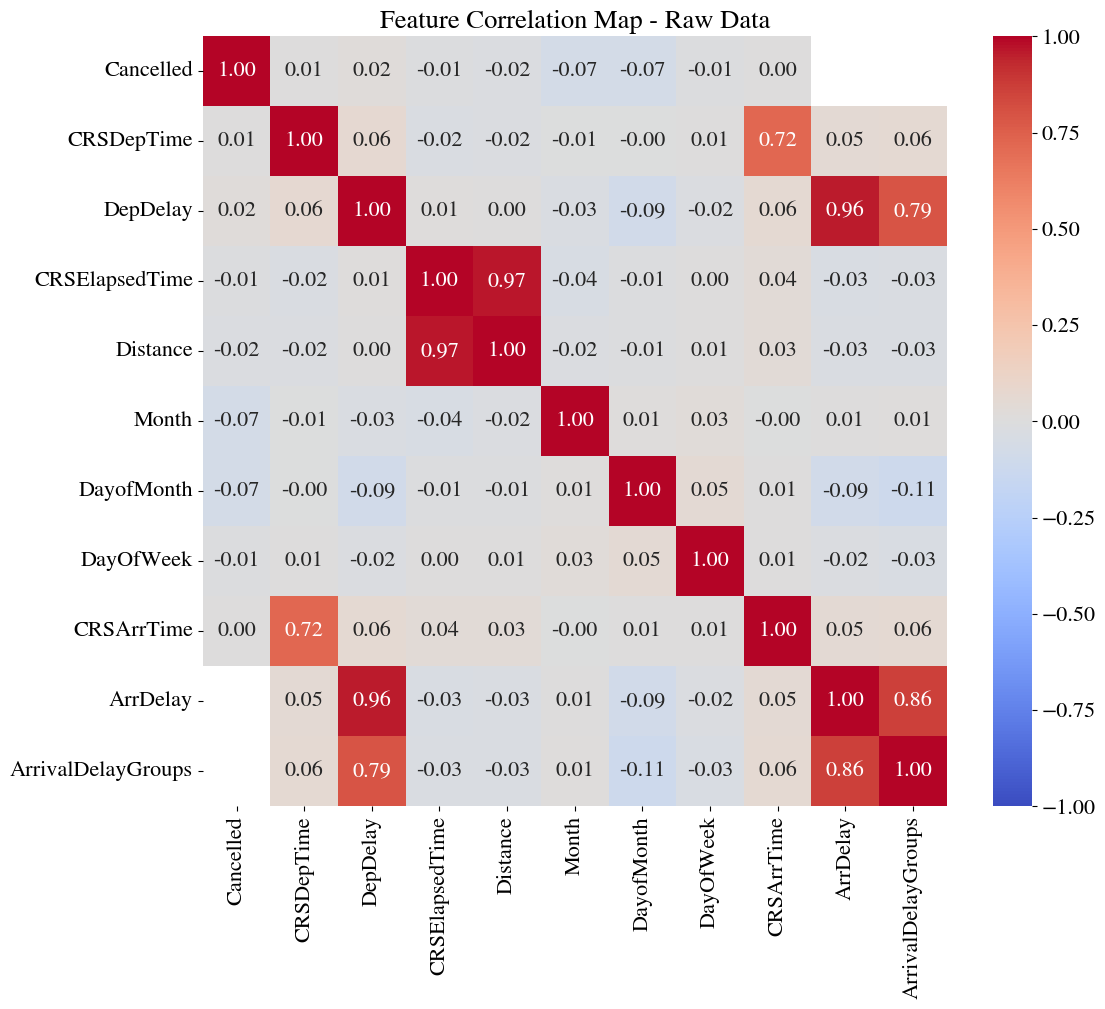

In [2]:
### Correlation matrix for raw data -------------------------------------------- 

# Calculate correlation matrix for raw data
corr_matrix_raw = df.corr()

# Plot heatmap for raw data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_raw, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Map - Raw Data')
plt.show()

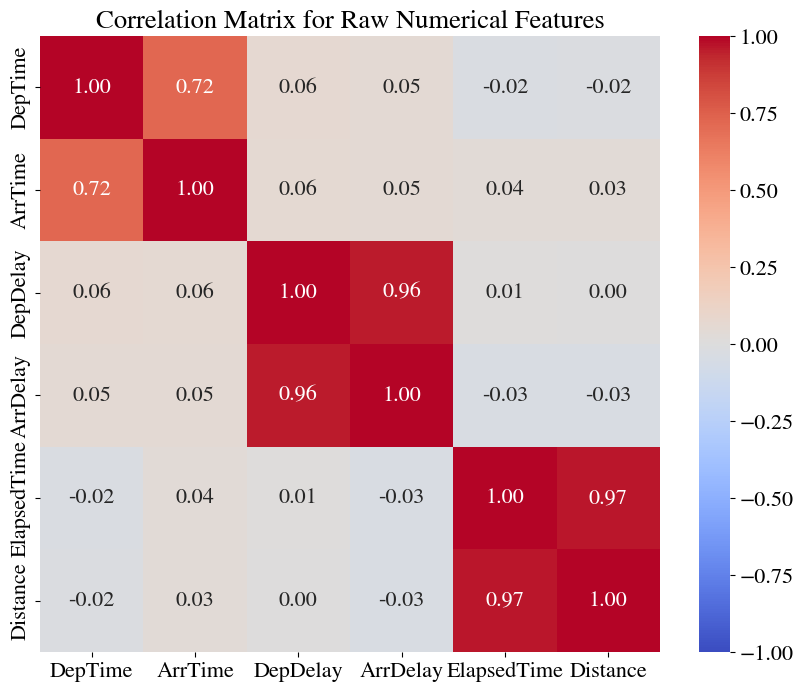

In [3]:
### Correlation matrix for numerical data 

# Raw numerical data ----------------------------------------------------------- 
numerical_features = ['DepTime', 'ArrTime', 'DepDelay', 'ArrDelay', 'ElapsedTime', 'Distance'] 

# Select subset 
numerical_data = df_new[numerical_features] 
# Calculate the correlation matrix
corr_matrix = numerical_data.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Raw Numerical Features')
plt.show()

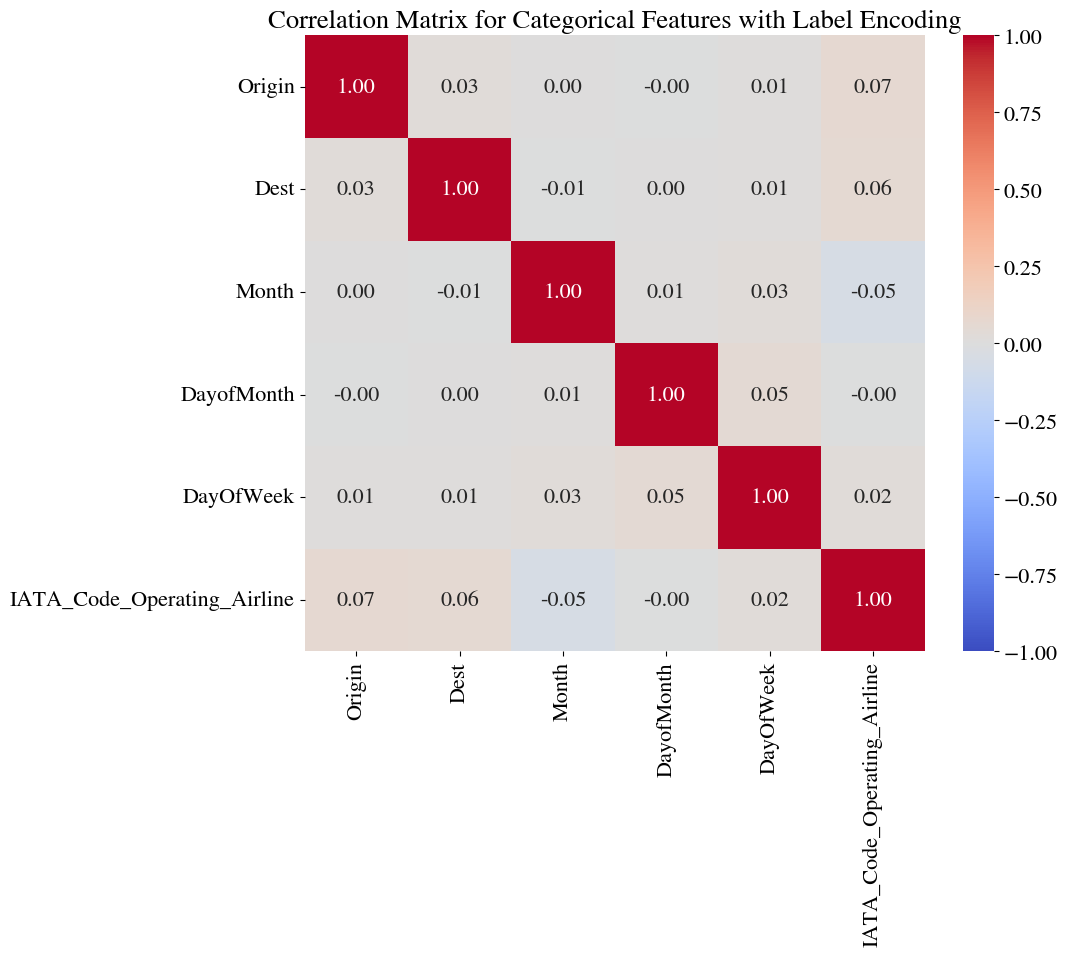

In [4]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical variables 
categorical_features = ['Origin', 'Dest', 'Month', 'DayofMonth', 'DayOfWeek', 'IATA_Code_Operating_Airline']

# Make a copy of the original DataFrame for safety
df_categorical = df[categorical_features].copy()

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in categorical_features:
    df_categorical[col] = label_encoder.fit_transform(df[col])

# Calculate the correlation matrix
corr_matrix_categorical = df_categorical.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_categorical, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Categorical Features with Label Encoding')
plt.show()


In [ ]:
### Correlation Map for Processed Data --- This is gonna take several hours to run 
# Calculate correlation matrix for processed data
corr_matrix_processed = df_new.corr()

# Plot heatmap for processed data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_processed, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Map - Processed Data')
plt.show()


# Split data

In [5]:
# Split the data into features and target
X = df_new.drop(columns=['ArrDelay', 'ArrGroup']) # drop the target variable for regression (ArrDelay) and classification (ArrGroup)
y = df_new['ArrDelay']

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Now, split the training data into training and validation sets (89% training, 11% validation of the original dataset)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

# Separate numerical and categorical columns
numerical_columns = ['DepTime', 'ArrTime', 'DepDelay', 'ElapsedTime', 'Distance']
categorical_columns = X_train.columns.difference(numerical_columns)

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Fit and transform the scalers on the training data, then transform the validation and test data
# For normalization
X_train_norm = X_train.copy()
X_val_norm = X_val.copy()
X_test_norm = X_test.copy()

X_train_norm[numerical_columns] = minmax_scaler.fit_transform(X_train[numerical_columns])
X_val_norm[numerical_columns] = minmax_scaler.transform(X_val[numerical_columns])
X_test_norm[numerical_columns] = minmax_scaler.transform(X_test[numerical_columns])

# For standardization
X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_val_std[numerical_columns] = standard_scaler.transform(X_val[numerical_columns])
X_test_std[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

# Normalize and standardize target variable 
y_train_norm = minmax_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_norm = minmax_scaler.transform(y_val.values.reshape(-1, 1))
y_test_norm = minmax_scaler.transform(y_test.values.reshape(-1, 1))

y_train_std = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_std = standard_scaler.transform(y_val.values.reshape(-1, 1))
y_test_std = standard_scaler.transform(y_test.values.reshape(-1, 1))


# Feature Selection 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std, y_train.values.ravel(), eps=1e-6, max_iter=10000, tol=0.01)


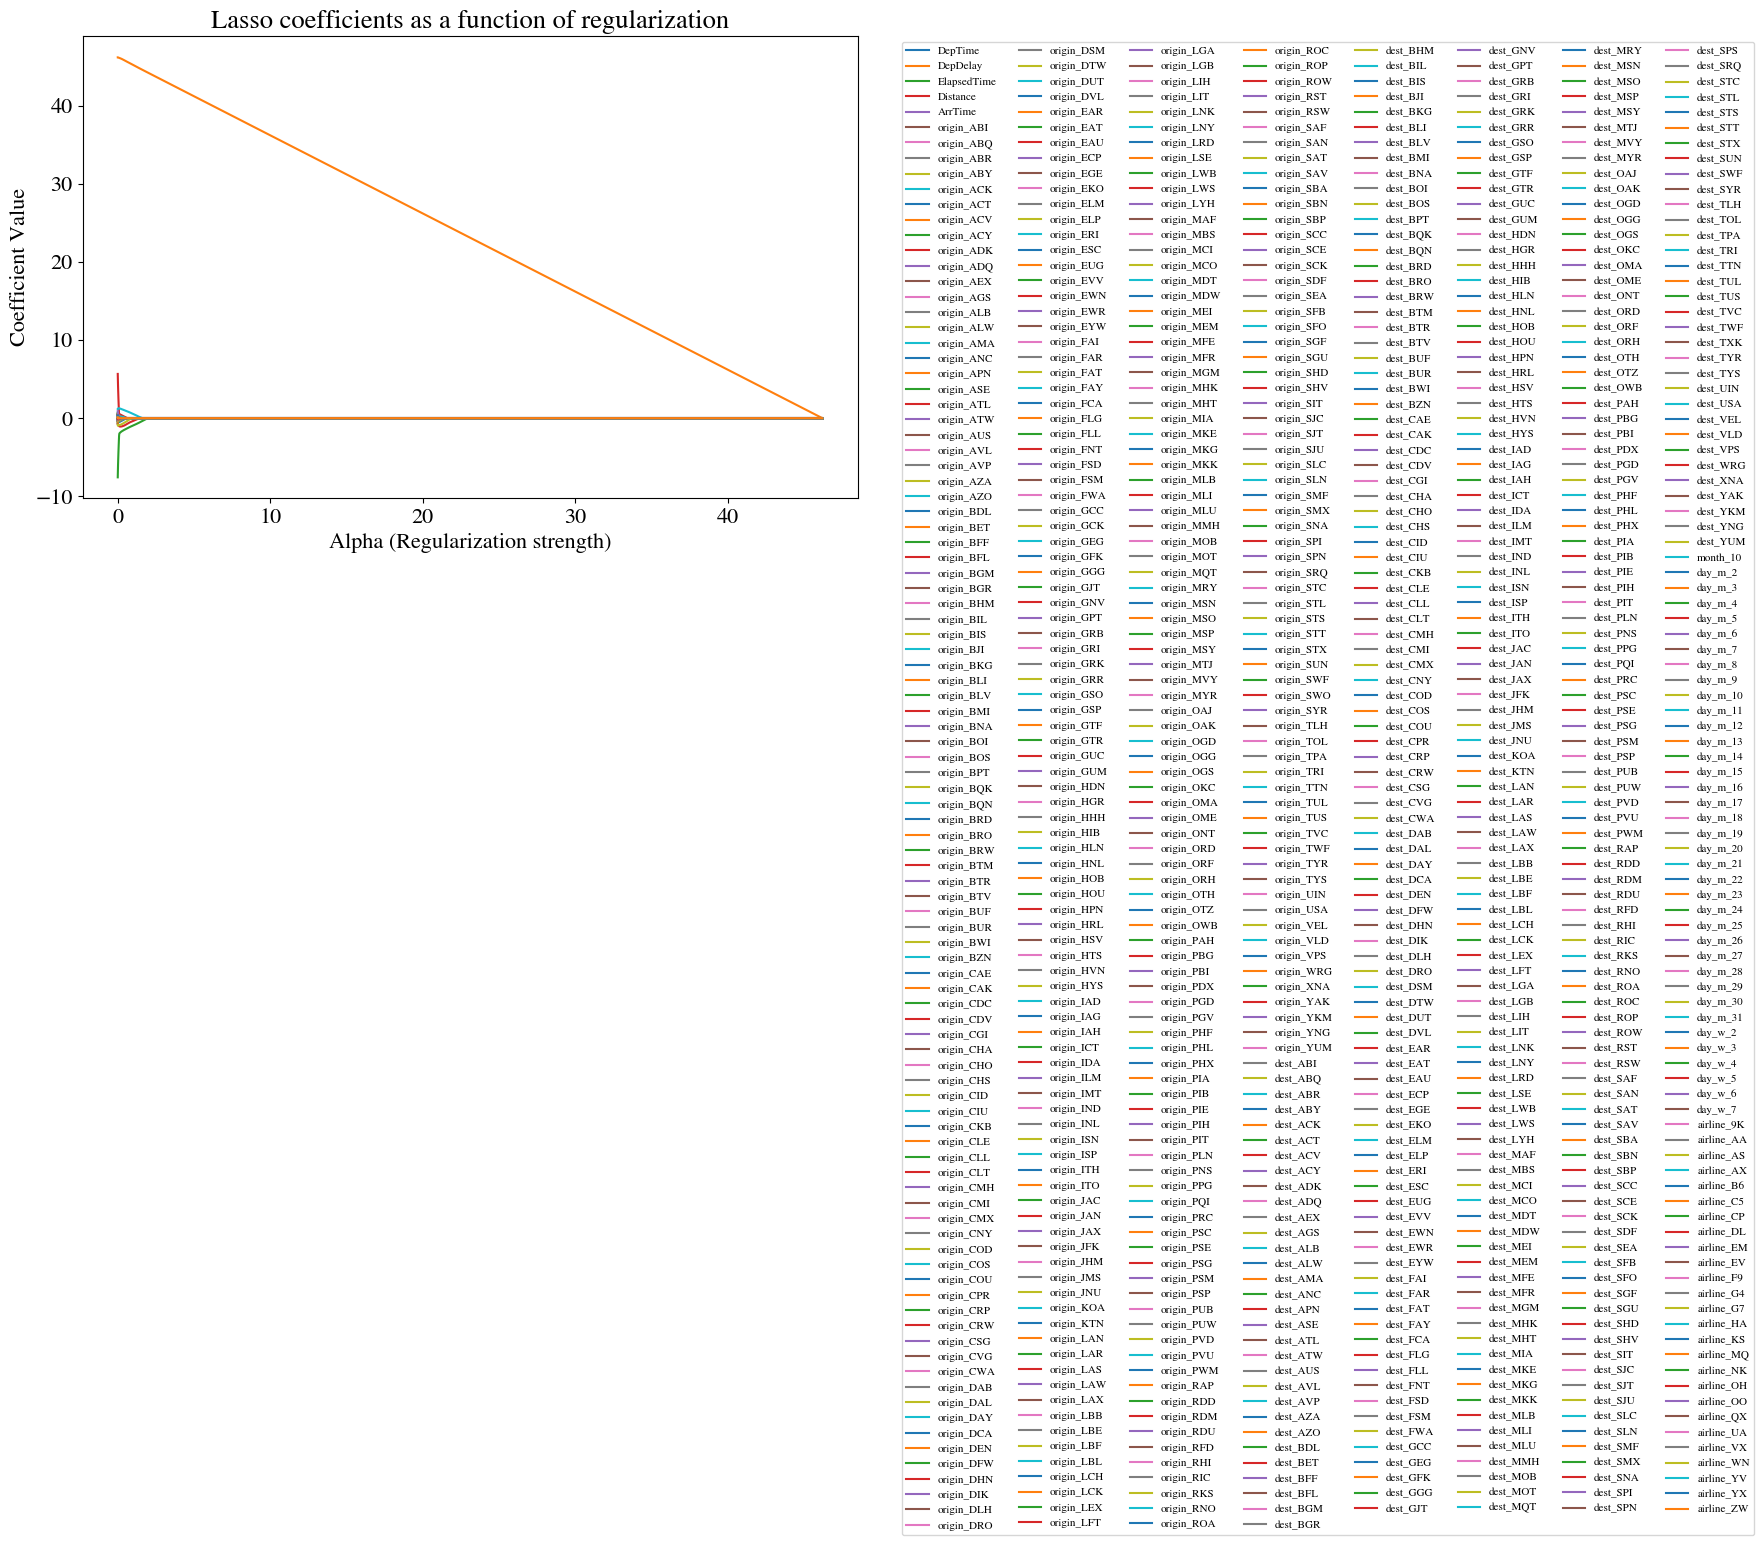

In [7]:
# Display results
plt.figure(figsize=(10, 6))

#neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, feature in zip(coefs_lasso, X_train.columns):
    plt.plot(alphas_lasso, coef_l, label=feature)

plt.xlabel('Alpha (Regularization strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a function of regularization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=8, fontsize=8)
plt.axis('tight')

plt.show()

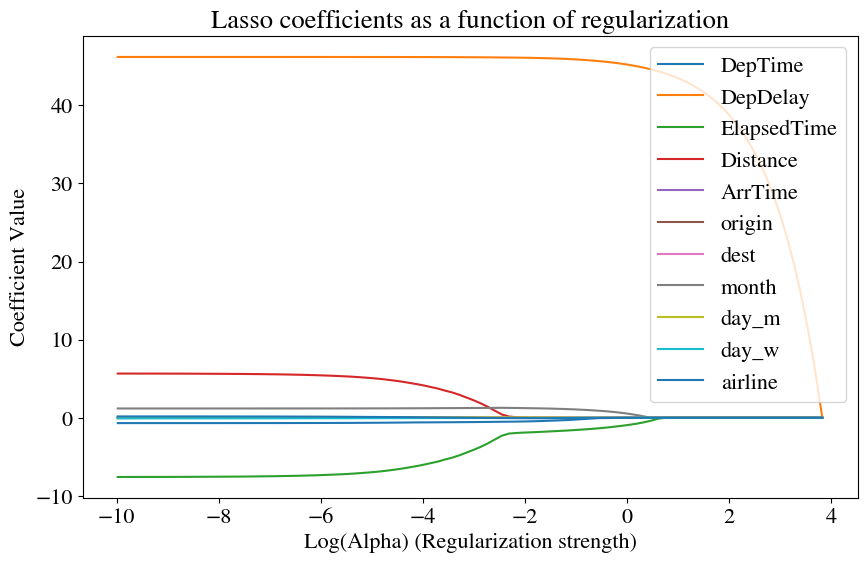

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler

# Assuming X_train_std and y_train are already defined

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_std, y_train.values.ravel(), eps=1e-6, max_iter=10000, tol=0.01)

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs_lasso, index=X_train.columns)

# Function to simplify labels
def simplify_label(label):
    parts = label.split('_')
    if len(parts) > 1:
        if 'day_m' in label or 'day_w' in label:
            return f"{parts[0]}_{parts[1]}"
        else:
            return f"{parts[0]}"
    return label

# Simplify labels
simplified_labels = coefs_df.index.to_series().apply(simplify_label).unique()

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through simplified labels to plot the paths
for label in simplified_labels:
    label_coefs = coefs_df.filter(regex=f'^{label}', axis=0)
    mean_coef_path = label_coefs.mean(axis=0)
    plt.plot(np.log(alphas_lasso), mean_coef_path, label=label)

# Customize plot
plt.xlabel('Log(Alpha) (Regularization strength)')
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients as a function of regularization')
plt.legend()
plt.axis('tight')

plt.show()

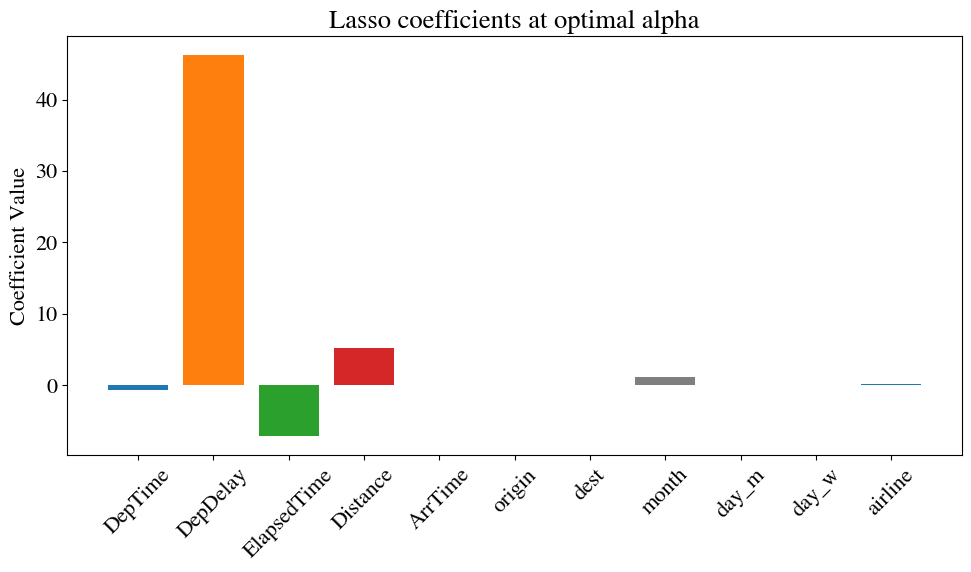

In [11]:
# Perform LassoCV
lasso_cv = LassoCV(cv=5, eps=1e-6, max_iter=10000, tol=0.01, random_state=42)
lasso_cv.fit(X_train_std, y_train.values.ravel())

# Get the coefficients
coefs = lasso_cv.coef_[np.newaxis, :]

# Create a DataFrame to make manipulation easier
coefs_df = pd.DataFrame(coefs, columns=X_train.columns)

# Function to simplify labels
def simplify_label(label):
    parts = label.split('_')
    if len(parts) > 1:
        if 'day_m' in label or 'day_w' in label:
            return f"{parts[0]}_{parts[1]}"
        else:
            return f"{parts[0]}"
    return label

# Simplify labels
simplified_labels = coefs_df.columns.to_series().apply(simplify_label).unique()

# Initialize plot
plt.figure(figsize=(10, 6))

# Loop through simplified labels to plot the coefficients
for label in simplified_labels:
    label_coefs = coefs_df.filter(regex=f'^{label}', axis=1)
    mean_coef = label_coefs.mean(axis=1)
    plt.bar(label, mean_coef)

# Customize plot
plt.ylabel('Coefficient Value')
plt.title('Lasso coefficients at optimal alpha')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print("Optimal Alpha Value:", lasso_cv.alpha_)

In [14]:
### Notes and TODOs ### 
'''
Based on correlation matrix, we can see that there are some features that are highly correlated with each other: 
1. DepDelay and ArrDelay --- This makes sence because if a flight departs late, it's also very likely to arrive late. 
Since ArrDelay is the target variable for regression, we will 
    a. Drop DepDelay to avoid overshadowing the effect of other features. 
    b. Keep DepDelay to see if it's a good predictor for regression. 
    c. Feature engineer a new feature called 'ArrDepDiff' to see if it's a good predictor for regression. 
2. Distance and ElapsedTime --- This makes sence because the longer the distance of a flight, the longer it's expected to be in the air. 
Since they are highly correlated, we will drop one of them to reduce multicollinearity. We will test both and see which one leads to better model performance. 
    a. Drop Distance 
    b. Drop ElapsedTime  

Another interesting observation is that the importance of month is pretty high among all the categorical features. 
This implies the seasonality of flight delays. We will keep an eye on this feature and see if it's a good predictor for regression. 

Now, before building the regression model, we are going to do feature selection using decision tree, and compare the results with Lasso and correlation matrix. 
'''

"\nBased on correlation matrix, we can see that there are some features that are highly correlated with each other: \n1. DepDelay and ArrDelay --- This makes sence because if a flight departs late, it's also very likely to arrive late. \nSince ArrDelay is the target variable for regression, we will \n    a. Drop DepDelay to avoid overshadowing the effect of other features. \n    b. Keep DepDelay to see if it's a good predictor for regression. \n    c. Feature engineer a new feature called 'ArrDepDiff' to see if it's a good predictor for regression. \n2. Distance and ElapsedTime --- This makes sence because the longer the distance of a flight, the longer it's expected to be in the air. \nSince they are highly correlated, we will drop one of them to reduce multicollinearity. We will test both and see which one leads to better model performance. \n    a. Drop Distance \n    b. Drop ElapsedTime  \n"

# Decision tree for feature importance 

# Model 1 - Linear regression 

In [12]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Lasso

In [ ]:
# Define the model
lasso = Lasso()

# Define hyperparameters for grid search
param_grid_lasso = {
    'polynomialfeatures__degree': [1, 2],  # degrees of the polynomial features
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]  # regularization strength
}

# ----------------- For Normalized Data -----------------
# Define the pipeline, including polynomial feature transformation and Lasso regression for normalized data
pipeline_lasso_norm = make_pipeline(PolynomialFeatures(), lasso)

# Set up the grid search for normalized data
grid_lasso_norm = GridSearchCV(pipeline_lasso_norm, param_grid_lasso, cv=5)

# Fit the model for normalized data
grid_lasso_norm.fit(X_train_norm, y_train_norm)

# Print the best parameters found for normalized data
print("Best parameters for Lasso (Normalized): ", grid_lasso_norm.best_params_)

# Make predictions for normalized data
y_pred_lasso_norm = grid_lasso_norm.predict(X_val_norm)

# Calculate Mean Squared Error for normalized data
mse_lasso_norm = mean_squared_error(y_val_norm, y_pred_lasso_norm)
print("Mean Squared Error for Lasso (Normalized): ", mse_lasso_norm)

# ----------------- For Standardized Data -----------------
# Define the pipeline, including polynomial feature transformation and Lasso regression for standardized data
pipeline_lasso_std = make_pipeline(PolynomialFeatures(), lasso)

# Set up the grid search for standardized data
grid_lasso_std = GridSearchCV(pipeline_lasso_std, param_grid_lasso, cv=5)

# Fit the model for standardized data
grid_lasso_std.fit(X_train_std, y_train_std)

# Print the best parameters found for standardized data
print("Best parameters for Lasso (Standardized): ", grid_lasso_std.best_params_)

# Make predictions for standardized data
y_pred_lasso_std = grid_lasso_std.predict(X_val_std)

# Calculate Mean Squared Error for standardized data
mse_lasso_std = mean_squared_error(y_val_std, y_pred_lasso_std)
print("Mean Squared Error for Lasso (Standardized): ", mse_lasso_std)


# Visualization 

In [ ]:
### True vs. Predicted 
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# For Normalized Data
axs[0].scatter(y_val_norm, y_pred_lasso_norm, alpha=0.5)
axs[0].plot([y_val_norm.min(), y_val_norm.max()], [y_val_norm.min(), y_val_norm.max()], '--k')
axs[0].set_xlabel('True Value')
axs[0].set_ylabel('Predicted Value')
axs[0].set_title('True vs Predicted Value (Normalized)')

# For Standardized Data
axs[1].scatter(y_val_std, y_pred_lasso_std, alpha=0.5, color='orange')
axs[1].plot([y_val_std.min(), y_val_std.max()], [y_val_std.min(), y_val_std.max()], '--k')
axs[1].set_xlabel('True Value')
axs[1].set_ylabel('Predicted Value')
axs[1].set_title('True vs Predicted Value (Standardized)')

plt.tight_layout()
plt.show()

In [ ]:
### Residuals Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# For Normalized Data
axs[0].scatter(y_pred_lasso_norm, y_val_norm - y_pred_lasso_norm, alpha=0.5)
axs[0].hlines(0, y_pred_lasso_norm.min(), y_pred_lasso_norm.max(), colors='r', linestyles='--')
axs[0].set_xlabel('Predicted Value')
axs[0].set_ylabel('Residual')
axs[0].set_title('Residuals Plot (Normalized)')

# For Standardized Data
axs[1].scatter(y_pred_lasso_std, y_val_std - y_pred_lasso_std, alpha=0.5, color='orange')
axs[1].hlines(0, y_pred_lasso_std.min(), y_pred_lasso_std.max(), colors='r', linestyles='--')
axs[1].set_xlabel('Predicted Value')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals Plot (Standardized)')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(pipeline_lasso_norm, X_train_norm, y_train_norm, cv=5)


### Learning Curve 
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# For Normalized Data
train_sizes, train_scores, validation_scores = learning_curve(pipeline_lasso_norm, X_train_norm, y_train_norm, cv=5)
axs[0].plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training Score')
axs[0].plot(train_sizes, -validation_scores.mean(axis=1), 'o-', label='Cross-validation Score')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('Negative Mean Squared Error')
axs[0].set_title('Learning Curve (Normalized)')
axs[0].legend()

# For Standardized Data
train_sizes, train_scores, validation_scores = learning_curve(pipeline_lasso_std, X_train_std, y_train_std, cv=5)
axs[1].plot(train_sizes, -train_scores.mean(axis=1), 'o-', label='Training Score', color='orange')
axs[1].plot(train_sizes, -validation_scores.mean(axis=1), 'o-', label='Cross-validation Score', color='green')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('Negative Mean Squared Error')
axs[1].set_title('Learning Curve (Standardized)')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# For Normalized Data
pipeline_lasso_norm_best = grid_lasso_norm.best_estimator_
feature_names_norm = np.array(pipeline_lasso_norm_best.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X_train_norm.columns))
coefficients_norm = pipeline_lasso_norm_best.named_steps['lasso'].coef_
sorted_idx_norm = np.argsort(abs(coefficients_norm))

# For Standardized Data
pipeline_lasso_std_best = grid_lasso_std.best_estimator_
feature_names_std = np.array(pipeline_lasso_std_best.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X_train_std.columns))
coefficients_std = pipeline_lasso_std_best.named_steps['lasso'].coef_
sorted_idx_std = np.argsort(abs(coefficients_std))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Normalized Data
axs[0].barh(feature_names_norm[sorted_idx_norm], coefficients_norm[sorted_idx_norm])
axs[0].set_xlabel('Coefficient Value')
axs[0].set_title('Lasso Coefficients (Normalized)')

# Plot for Standardized Data
axs[1].barh(feature_names_std[sorted_idx_std], coefficients_std[sorted_idx_std], color='orange')
axs[1].set_xlabel('Coefficient Value')
axs[1].set_title('Lasso Coefficients (Standardized)')

plt.tight_layout()
plt.show()


## Ridge 

In [ ]:
# Define the model
ridge = Ridge()

# Define hyperparameters for grid search
param_grid_ridge = {
    'polynomialfeatures__degree': [1, 2, 3],  # degrees of the polynomial features
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10]  # regularization strength
}

# ----------------- For Normalized Data -----------------
# Define the pipeline, including polynomial feature transformation and Ridge regression for normalized data
pipeline_ridge_norm = make_pipeline(PolynomialFeatures(), ridge)

# Set up the grid search for normalized data
grid_ridge_norm = GridSearchCV(pipeline_ridge_norm, param_grid_ridge, cv=5)

# Fit the model for normalized data
grid_ridge_norm.fit(X_train_norm, y_train_norm)

# Print the best parameters found for normalized data
print("Best parameters for Ridge (Normalized): ", grid_ridge_norm.best_params_)

# Make predictions for normalized data
y_pred_ridge_norm = grid_ridge_norm.predict(X_val_norm)

# Calculate Mean Squared Error for normalized data
mse_ridge_norm = mean_squared_error(y_val_norm, y_pred_ridge_norm)
print("Mean Squared Error for Ridge (Normalized): ", mse_ridge_norm)

# ----------------- For Standardized Data -----------------
# Define the pipeline, including polynomial feature transformation and Ridge regression for standardized data
pipeline_ridge_std = make_pipeline(PolynomialFeatures(), ridge)

# Set up the grid search for standardized data
grid_ridge_std = GridSearchCV(pipeline_ridge_std, param_grid_ridge, cv=5)

# Fit the model for standardized data
grid_ridge_std.fit(X_train_std, y_train_std)

# Print the best parameters found for standardized data
print("Best parameters for Ridge (Standardized): ", grid_ridge_std.best_params_)

# Make predictions for standardized data
y_pred_ridge_std = grid_ridge_std.predict(X_val_std)

# Calculate Mean Squared Error for standardized data
mse_ridge_std = mean_squared_error(y_val_std, y_pred_ridge_std)
print("Mean Squared Error for Ridge (Standardized): ", mse_ridge_std)
